# Классификация спама в электронной почте

## Задача проекта
Обучить модель классифицировать сообщения в почте на спам / не спам. В нашем распоряжении набор данных с разметкой о том, что является спамом. Качество модели должно быть со значением метрики качества F1 не меньше 0.75.

## Методология проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.

#### Используем три подхода для препроцессинга текста: логрегрессия + мешок слов, затем попробуем word2vec и наконец Fasttext. Таким образом выберем наилучший вариант обработки для обучения модели.

In [2]:
from functools import lru_cache

import fasttext.util
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров

from sklearn.pipeline import Pipeline

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных

In [4]:
df = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_EmailSpamClassifier\\spam.csv")
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Изучим целевую переменную label.

In [5]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [6]:
# проверка таргета на дисбаланс
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
# проверка на пропуски в таргете
df['label'].isna().sum()

0

In [8]:
data = df.copy()

In [9]:
# перекодируем таргет цифрами
data['label'] = data['label'].replace({'ham': 0, 'spam': 1})
data.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


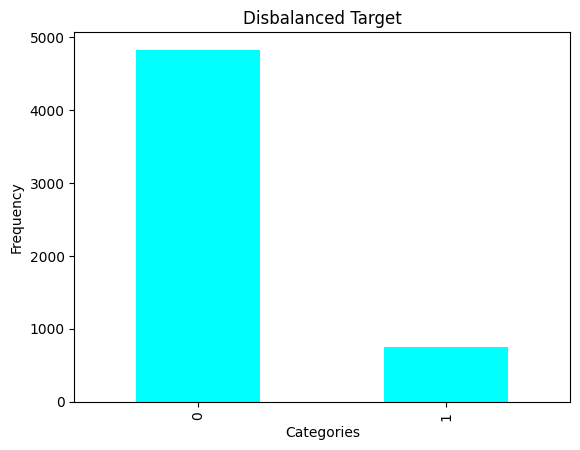

In [10]:
data['label'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

### Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [11]:
train, test = train_test_split(data, test_size=0.2)

In [12]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [13]:
train.sample()

,label,text
5491,0,U studying in sch or going home? Anyway i'll b...


In [14]:
test.sample()

,label,text
3525,0,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...


In [15]:
y_train.sample()

,label
2069,1


In [16]:
y_test.sample()

,label
4051,0


In [17]:
y_test = y_test['label'].values
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [19]:
bow = vec.fit_transform(train['text'])

In [20]:
bow

<4457x7413 sparse matrix of type '<class 'numpy.int64'>'
	with 47744 stored elements in Compressed Sparse Row format>

In [21]:
print(train.text[333])

Any chance you might have had with me evaporated as soon as you violated my privacy by stealing my phone number from your employer's paperwork. Not cool at all. Please do not contact me again or I will report you to your supervisor.


In [22]:
list(vec.vocabulary_.items())[:10]

[('send', 5754),
 ('birthdate', 1282),
 ('with', 7228),
 ('month', 4385),
 ('and', 893),
 ('year', 7344),
 ('will', 7201),
 ('tel', 6468),
 ('life', 3924),
 ('partner', 4866)]

In [23]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000pes', 1),
 ('008704050406', 2),
 ('0089', 3),
 ('0121', 4),
 ('01223585236', 5),
 ('01223585334', 6),
 ('0125698789', 7),
 ('0207', 8),
 ('02072069400', 9)]

In [24]:
list(vec.vocabulary_.keys())[:10]

['staff',
 'placement',
 'training',
 'amrita',
 'college',
 'cps',
 'causing',
 'the',
 'outages',
 'conserve']

In [25]:
len(vec.vocabulary_.items())

7507

### Logistic Regression (baseline)

In [27]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [28]:
len(clf.coef_[0])

7507

In [29]:
bow_test = vec.transform(test['text'])
bow_test

<1115x7507 sparse matrix of type '<class 'numpy.int64'>'
	with 10940 stored elements in Compressed Sparse Row format>

In [30]:
pred = clf.predict(bow_test)
pred[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [31]:
accuracy_score(pred, y_test)

0.9811659192825112

In [32]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       999
           1       0.86      0.98      0.92       116

    accuracy                           0.98      1115
   macro avg       0.93      0.98      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### *Вывод:*

**В данном случае, модель показала высокую точность (precision) и полноту (recall) для класса 0, а также высокую точность для класса 1. Однако полнота для класса 1 немного ниже, чем для класса 0, что может означать, что модель не совсем точно определяет объекты этого класса.**

Также стоит обратить внимание на F1-меру, которая учитывает как точность, так и полноту. F1-мера равна 0.92 для класса 1, что может говорить о том, что модель делает ошибки в классификации этого класса.

* Precision (точность) - это доля истинно положительных результатов из всех положительных результатов, которые модель предсказала. Для класса 0 точность равна 1.0, а для класса 1 - 0.85.

* Recall (полнота) - это доля истинно положительных результатов, которые модель предсказала, относительно всех реальных положительных результатов. Для класса 0 полнота равна 0.98, а для класса 1 - 0.99.

* F1-score - это среднее гармоническое между точностью и полнотой. Он показывает, насколько хорошо модель справляется с обнаружением положительных результатов. F1-мера равна 0,99 для класса 0 и 0,92 для класса 1.

* Support - это количество примеров каждого класса в тестовом наборе данных.

* Accuracy (точность классификации) - это доля правильно классифицированных примеров. Здесь она равна 0,98.

* Macro avg - это среднее значение метрик (precision, recall, f1-score) для каждого класса без учета их дисбаланса. В данном случае, macro avg precision, recall и f1-score равны 0,93.

* Weighted avg - это взвешенное среднее метрик с учетом дисбаланса классов. В данном случае, weighted avg precision, recall и f1-score равны 0,98.

#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

In [33]:
# !pip install pymorphy2 -qq

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [115]:
import re

In [116]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
regex = re.compile("[a-z]+")

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

In [117]:
# testing the function
train.text[1]

'Ok lar... Joking wif u oni...'

In [118]:
words_only(train.text[1])

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

In [119]:
# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

mystopwords = stopwords.words('english')

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [120]:
%time lemmatize_word('outstanding world')

CPU times: total: 0 ns
Wall time: 1 ms


'outstanding world'

In [121]:
train.text[1]

'Ok lar... Joking wif u oni...'

In [122]:
# testing the cleaning functions
clean_text(train.text[1])

'joking'

#### Функции работают, проводим препроцессинг для train и test выборок.

In [123]:
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 4457/4457 [00:00<00:00, 5872.78it/s]


,label,text,lemmas,w2v_embedding,ft_embedding
4207,0,Or i go home first lar Ì_ wait 4 me lor.. I pu...,home first wait stuff first,"[-0.000543399597518146, 0.03698877617716789, 0...","[0.05041737146010356, -0.05347472412644753, -0..."
4902,0,"\I;m reaching in another 2 stops.\""""",reaching another stops,"[-0.00041641556890681386, 0.02654660865664482,...","[0.013876400189474225, -0.040173141402192414, ..."
5276,0,Dunno leh cant remember mayb lor. So wat time ...,dunno cant remember mayb time meeting,"[-0.0013092289979492004, 0.026340352992216747,...","[-0.009408633379886547, -0.06609238358214498, ..."
681,0,ÌÏ log off 4 wat. It's sdryb8i,sdryb,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.029583919793367386, 0.06998465093784034, 0...."
4610,0,Wat time Ì_ finish?,time finish,"[-0.0004960598307661712, 0.04001572635024786, ...","[0.020060984417796135, -0.01158096082508564, -..."


In [124]:
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 1115/1115 [00:00<00:00, 5956.86it/s]


,label,text,lemmas,w2v_embedding,ft_embedding
1471,0,Oh. U must have taken your REAL Valentine out ...,must taken real valentine shopping first,"[0.0016672755009494722, 0.027477499097585678, ...","[0.021809755147180775, -0.043560537763617256, ..."
4199,0,I will come tomorrow di,come tomorrow,"[0.0017443140968680382, 0.03964747488498688, 0...","[-0.04405460488051176, -0.015770922973752023, ..."
2134,0,If he started searching he will get job in few...,started searching days great potential talent,"[-0.002422505902359262, 0.028905640977124374, ...","[0.018386028396586578, -0.04373697893073161, 0..."
3514,0,I'm job profile seems like bpo..,profile seems like,"[-0.007187643088400364, 0.055316630750894547, ...","[0.021234225761145354, 0.06216824539005757, 0...."
3708,0,Ok.ok ok..then..whats ur todays plan,whats todays plan,"[0.0012923784088343382, 0.016592067355910938, ...","[0.0545611617465814, -0.04441642062738538, 0.0..."


#### Считаем TF-IDF матрицу и обучаем модель:

In [125]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

0.9390134529147982

In [126]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1040
           1       0.53      0.93      0.67        75

    accuracy                           0.94      1115
   macro avg       0.76      0.94      0.82      1115
weighted avg       0.96      0.94      0.95      1115



### Word2Vec

Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.

In [127]:
train.sample()

,label,text,lemmas,w2v_embedding,ft_embedding
4035,0,How are you holding up?,holding,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02890441135969013, -0.03259328380227089, 0...."


In [128]:
tokenized_emails = [email.split() for email in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_emails, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [129]:
tokenized_emails

[['staff', 'placement', 'training', 'amrita', 'college'],
 ['causing', 'outages', 'conserve', 'energy'],
 ['many', 'unfortunately', 'pics', 'obviously', 'arent', 'cakes', 'kinda'],
 ['pete', 'please', 'ring', 'meive', 'hardly', 'gotany', 'credit'],
 ['almost'],
 ['ummmmmaah',
  'many',
  'many',
  'happy',
  'returns',
  'dear',
  'sweet',
  'heart',
  'happy',
  'birthday',
  'dear'],
 ['sorry', 'call', 'later'],
 ['feel', 'real', 'valentine', 'valentine', 'even', 'hardly', 'play'],
 ['nosy', 'guess', 'reacting', 'freaked'],
 ['nice', 'dear'],
 ['engalnd', 'telly', 'decided', 'watch', 'elliot', 'kissing', 'damn'],
 ['regret',
  'inform',
  'made',
  'mistake',
  'never',
  'actually',
  'born',
  'please',
  'report',
  'local',
  'hospital',
  'terminated',
  'sorry',
  'inconvenience'],
 ['trip', 'postponed', 'still', 'stocked'],
 [],
 ['finish', 'watching'],
 ['rather', 'prominent', 'bite', 'mark', 'right', 'cheek'],
 ['friendship',
  'game',
  'play',
  'word',
  'start',
  'march

In [130]:
w2v.wv.most_similar(positive=['good'], topn=10)

[('love', 0.9997051358222961),
 ('back', 0.9996834397315979),
 ('need', 0.9996771216392517),
 ('hope', 0.9996660351753235),
 ('make', 0.9996634125709534),
 ('things', 0.9996599555015564),
 ('call', 0.9996588230133057),
 ('said', 0.9996576905250549),
 ('cash', 0.9996487498283386),
 ('someone', 0.9996469616889954)]

Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для емейлов?
Можно просто усреднить эмбеддинги слов, входящих в емейл.

In [131]:
def get_email_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [132]:
get_email_embedding('text')

array([ 0.00298305,  0.05603025,  0.04381673,  0.2216216 ,  0.19776689,
       -0.28281066, -0.0683917 ,  0.38134679, -0.04561968,  0.25412065,
       -0.20571817, -0.18839239,  0.05608255,  0.20797458, -0.14908552,
       -0.20357999, -0.01408905, -0.00801768,  0.04463589, -0.41976711,
        0.16608368, -0.21706545, -0.01851481,  0.07067773, -0.00548425,
       -0.0770468 , -0.15040943, -0.2345549 , -0.09445211,  0.14942527,
        0.27587557,  0.07912114,  0.08564716,  0.12001693, -0.05090627,
        0.14225125,  0.16000345, -0.14343773, -0.11759694, -0.32410309,
       -0.16749564,  0.01244746,  0.0728224 ,  0.07938295,  0.35852426,
        0.02928632, -0.10793351, -0.09462432,  0.12671292,  0.15120055,
        0.10938895, -0.06112665, -0.24017516, -0.18121615,  0.04513235,
       -0.0113148 , -0.03162394, -0.10063913, -0.30887824, -0.07722541,
       -0.02723734,  0.07230541, -0.16119006, -0.1643787 , -0.31578314,
       -0.04483589,  0.04857713,  0.35008702, -0.26690808,  0.20

Для каждого email из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [133]:
test.sample()

,label,text,lemmas,w2v_embedding,ft_embedding
3107,0,Hello hun how ru? Its here by the way. Im good...,hello good dates walkabout meet soon hows ever...,"[-0.0012420550753761614, 0.02923354439969574, ...","[0.01866847068642176, -0.01585730581334041, 0...."


In [134]:
train['w2v_embedding'] = train['lemmas'].map(get_email_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_email_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

0.8789237668161435

In [135]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1111
           1       0.01      0.25      0.01         4

    accuracy                           0.88      1115
   macro avg       0.50      0.57      0.48      1115
weighted avg       0.99      0.88      0.93      1115



### *Вывод:*

#### Для класса 0 модель показывает высокую точность (precision) - 1.0 и низкую полноту (recall) - 0.87, что может означать, что модель хорошо относит объекты к классу 0, но может пропустить некоторые объекты, которые на самом деле принадлежат к этому классу.

#### Для класса 1 модель показывает низкую точность - 0.0 и полноту - 0.0, что говорит о том, что модель не смогла распознать ни один объект этого класса.

#### Accuracy модели составляет 0.87, что может показаться неплохим результатом, однако этот показатель может быть обманчивым, особенно при работе с несбалансированными классами.

#### Macro avg и weighted avg F1-score показывают, что модель не справляется хорошо с обнаружением объектов класса 1.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [136]:
# !pip install fasttext==0.9.2

In [137]:
# !pip install fasttext-wheel

In [138]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [139]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian
# fasttext.util.download_model('en', if_exists='ignore') # english ==> ЗАГРУЖЕНА ЛОКАЛЬНО

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
# Загрузка модели в переменную ft
# ft = fasttext.load_model('cc.ru.300.bin')
# ft = fasttext.load_model('cc.en.300.bin')

ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.en.300.bin")

In [59]:
ft['hello there']

array([-2.44131102e-03,  6.86634844e-03, -4.64297691e-03,  5.68052717e-02,
       -8.97633377e-03, -4.34392244e-02, -4.15134765e-02, -1.96466725e-02,
       -1.92641281e-02,  3.78250182e-02,  1.11727994e-02, -7.56735215e-04,
        1.16112689e-02, -1.02469735e-02,  2.12699939e-02, -1.27778742e-02,
        2.78060678e-02, -3.84030328e-03,  5.82022453e-03,  6.13621138e-02,
       -3.29374447e-02,  2.77478788e-02, -2.64538289e-03,  1.31018646e-02,
        4.29556891e-02,  3.20734307e-02,  2.35034321e-02,  3.64242829e-02,
        1.46307768e-02, -1.09952707e-02,  1.80780480e-03,  4.46964875e-02,
        2.41486672e-02,  3.29661109e-02,  2.65991520e-02,  1.39829051e-02,
       -1.91206783e-02,  9.06543359e-02,  1.01913642e-02,  1.46549726e-02,
       -2.65019294e-02, -2.43958365e-02,  3.87098975e-02,  2.88005592e-03,
       -3.42124514e-02, -7.70211732e-03, -1.03406636e-02,  1.95757486e-02,
       -4.01332974e-03,  3.15076858e-02,  8.09701346e-03, -2.69619655e-02,
        1.27951773e-02, -

In [60]:
x = 'hello everybody'
get_email_embedding(x, model=ft, embedding_size=300)

array([ 0.09789046,  0.04046126,  0.00286576,  0.07163598,  0.00107945,
        0.00910006,  0.01383169, -0.00856619,  0.00804276,  0.03836769,
       -0.01619244, -0.01600526, -0.05596297,  0.02747893,  0.14061472,
        0.02049343,  0.01020226, -0.03844588, -0.05681249,  0.05367368,
       -0.01524684,  0.01843753, -0.04520749,  0.01789936,  0.00734114,
       -0.03049576,  0.00927637,  0.02301236, -0.04156304,  0.07006981,
       -0.05795917, -0.02243821,  0.01043514,  0.01216725, -0.01421282,
       -0.00412487,  0.05181427,  0.05744778, -0.03657544, -0.01166686,
       -0.05278298, -0.01856061, -0.01276752,  0.03989806,  0.02795554,
        0.00990125, -0.0142828 ,  0.03953332, -0.02063946,  0.06250986,
        0.02253822, -0.0720943 ,  0.09007107, -0.03542015, -0.01970844,
       -0.01840877,  0.01657757,  0.06814404, -0.01946214, -0.01990669,
       -0.02995278,  0.04302351, -0.05441403,  0.02654148,  0.05754455,
        0.04096775, -0.02585623,  0.03574964,  0.02606734, -0.01

In [61]:
train['ft_embedding'] = train['text'].apply(lambda x: get_email_embedding(x, model=ft, embedding_size=300))
print('train done')

test['ft_embedding'] = test['text'].apply(lambda x: get_email_embedding(x, model=ft, embedding_size=300))

train done


In [63]:
train.head()

,label,text,lemmas,w2v_embedding,ft_embedding
3512,0,Staff of placement training in Amrita college.,staff placement training amrita college,"[0.00031061924528330564, 0.010601486079394817,...","[-0.00959715200068396, -0.03786172198929957, -..."
3601,0,Cps is causing the outages to conserve energy.,causing outages conserve energy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.031687527953181416, -0.058610507752746344,..."
2371,0,"Hmm, too many of them unfortunately... Pics ob...",many unfortunately pics obviously arent cakes ...,"[-0.002228397657745518, 0.02354218205437064, 0...","[0.02275296327794562, -0.02210996034913338, -0..."
587,0,\Pete can you please ring meive hardly gotany ...,pete please ring meive hardly gotany credit,"[0.000410129160930713, 0.022921637011071045, 0...","[0.02622615210711956, 0.00964561030268669, 0.0..."
480,0,"Almost there, see u in a sec",almost,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06951984536967107, -0.11175210507852691, 0...."


In [64]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

pred = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9542600896860987

In [65]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       999
           1       0.74      0.85      0.80       116

    accuracy                           0.95      1115
   macro avg       0.86      0.91      0.88      1115
weighted avg       0.96      0.95      0.96      1115



### Разделим выборку на подвыборки признаков и целевой переменной.

In [67]:
train.head(10)

,label,text,lemmas,w2v_embedding,ft_embedding
3512,0,Staff of placement training in Amrita college.,staff placement training amrita college,"[0.00031061924528330564, 0.010601486079394817,...","[-0.00959715200068396, -0.03786172198929957, -..."
3601,0,Cps is causing the outages to conserve energy.,causing outages conserve energy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.031687527953181416, -0.058610507752746344,..."
2371,0,"Hmm, too many of them unfortunately... Pics ob...",many unfortunately pics obviously arent cakes ...,"[-0.002228397657745518, 0.02354218205437064, 0...","[0.02275296327794562, -0.02210996034913338, -0..."
587,0,\Pete can you please ring meive hardly gotany ...,pete please ring meive hardly gotany credit,"[0.000410129160930713, 0.022921637011071045, 0...","[0.02622615210711956, 0.00964561030268669, 0.0..."
480,0,"Almost there, see u in a sec",almost,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06951984536967107, -0.11175210507852691, 0...."
1250,0,Ummmmmaah Many many happy returns of d day my ...,ummmmmaah many many happy returns dear sweet h...,"[-0.004145646234974265, 0.03875032543308205, 0...","[0.031044056194122486, -0.03416430305403013, -..."
2384,0,"Sorry, I'll call later",sorry call later,"[0.0012110385578125715, 0.046027008444070816, ...","[0.01660650223493576, 0.06182510366973778, 0.0..."
1536,0,How's it feel? Mr. Your not my real Valentine ...,feel real valentine valentine even hardly play,"[0.0012089292577002198, 0.03758943174034357, 0...","[0.054683612651812534, -0.05569582556684812, -..."
1576,0,No. To be nosy I guess. Idk am I over reacting...,nosy guess reacting freaked,"[0.0036569610238075256, 0.026117848232388496, ...","[0.005178493519241993, -0.06420703031695806, 0..."
3958,0,Have a nice day my dear.,nice dear,"[-0.0015286598354578018, 0.041159454733133316,...","[0.10706881495813529, -0.11395440995693207, -0..."


In [68]:
test.head(10)

,label,text,lemmas,w2v_embedding,ft_embedding
2262,0,It should take about &lt;#&gt; min,take,"[-0.004520016256719828, 0.045791979879140854, ...","[0.01590464962646365, 0.0008068623021245003, -..."
5225,0,Smile in Pleasure Smile in Pain Smile when tro...,smile pleasure smile pain smile trouble pours ...,"[-0.0021381562342867254, 0.03738793069496751, ...","[0.03856497232336551, -0.028415523171424865, 0..."
4525,1,"I want some cock! My hubby's away, I need a re...",want cock hubby away need real satisfy wife st...,"[-0.0007700716572192808, 0.03537411273767551, ...","[0.02019495954404452, -0.04221223606145941, 0...."
3205,0,At home also.,home also,"[-5.6280987337231636e-05, 0.03414945397526026,...","[0.08650101100405057, 0.15684805903583765, -0...."
3326,0,what number do u live at? Is it 11?,number live,"[-0.0011079624528065324, 0.040454642847180367,...","[0.03724216014545943, -0.10008797781275851, 0...."
958,0,My sort code is and acc no is . The bank is n...,sort code bank natwest reply confirm sent righ...,"[-0.002346955647226423, 0.037857326492667195, ...","[0.016261394516649572, -0.015616868262771855, ..."
758,0,U should have made an appointment,made appointment,"[0.0005191086092963815, 0.019484184682369232, ...","[0.04234688247864445, -0.1692820672566692, 0.0..."
797,0,\Petey boy whereare you me and all your friend...,petey whereare friendsare thekingshead come ca...,"[0.002121462021023035, 0.04530158266425133, 0....","[0.0601345018314367, -0.08598910352553833, 0.0..."
2403,0,Jesus christ bitch I'm trying to give you drug...,jesus christ bitch trying give drugs answer fu...,"[-0.001611222978681326, 0.030241326708346606, ...","[0.008123037154571367, -0.006733958681042378, ..."
1616,0,"K, makes sense, btw carlos is being difficult ...",makes sense carlos difficult guys gonna smoke ...,"[-0.0037142281071282923, 0.02098093886992761, ...","[0.03580115882990261, -0.10056787772919051, 0...."


In [69]:
train.columns

Index(['label', 'text', 'lemmas', 'w2v_embedding', 'ft_embedding'], dtype='object')

In [70]:
# X_train = train.drop(columns=['label', 'text', 'lemmas', 'w2v_embedding'])
# y_train = train[['label']]
#
# X_test = test.drop(columns=['label', 'text', 'lemmas', 'w2v_embedding'])
# y_test = test[['label']]

In [71]:
# print('Размер выборки признаков для обучения:', X_train.shape[0])
# print('Размер выборки целевых значений для обучения:', y_train.shape[0])
# print()
# print('Размер выборки признаков для тестирования:', X_test.shape[0])
# print('Размер выборки целевых значений для тестирования:', y_test.shape[0])
# print()
# print('Размер выборки для тестирования, %:', round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]) * 100, 1))

#### Один из способов корректировки дисбаланса таргета - добавление в обучаемую модель аргумента: ```class_weight = 'balanced'```.

### *Вывод:* Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

In [72]:
print(train.shape)
print(y_train.shape)

(4457, 5)
(4457, 1)


## Модели
### 1) Логистическая регрессия

In [85]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

prediction = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 95.43%

f1-score: 0.9528949462052773%

 [[965  17]
 [ 34  99]]

               precision    recall  f1-score   support

           0       0.97      0.98      0.97       982
           1       0.85      0.74      0.80       133

    accuracy                           0.95      1115
   macro avg       0.91      0.86      0.88      1115
weighted avg       0.95      0.95      0.95      1115



Или с использованием контейнера.

In [74]:
pipe_lr = Pipeline([('model', LogisticRegression())])
pipe_lr.fit(train['ft_embedding'].values.tolist(), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('model', LogisticRegression())])

In [75]:
prediction = pipe_lr.predict(test['ft_embedding'].values.tolist())

In [76]:
print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 95.43%

f1-score: 0.9528949462052773%

 [[965  17]
 [ 34  99]]

               precision    recall  f1-score   support

           0       0.97      0.98      0.97       982
           1       0.85      0.74      0.80       133

    accuracy                           0.95      1115
   macro avg       0.91      0.86      0.88      1115
weighted avg       0.95      0.95      0.95      1115



**Для более точного подбора гиперпараметров применим поиск по сетке.**

In [98]:
%%time
logreg = LogisticRegression(class_weight='balanced', random_state=42)

param_grid = [
    {'C': [0.01, 0.1, 1, 2, 10, 100],
     'penalty': ['l1', 'l2']}
]

logreg_grid = GridSearchCV(logreg,
                           param_grid,
                           cv=3,
                           verbose=False,
                           n_jobs=-1,
                           scoring='f1')

logreg_grid.fit(train['ft_embedding'].values.tolist(), y_train)

pred_final = logreg_grid.predict(test['ft_embedding'].values.tolist())

print("\naccuracy: {}%".format(round(accuracy_score(y_test, pred_final)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, pred_final, average='weighted')))
print('\n',confusion_matrix(y_test, pred_final))
print('\n',classification_report(y_test, pred_final))


accuracy: 93.99%

f1-score: 0.9439430404145152

 [[923  59]
 [  8 125]]

               precision    recall  f1-score   support

           0       0.99      0.94      0.96       982
           1       0.68      0.94      0.79       133

    accuracy                           0.94      1115
   macro avg       0.84      0.94      0.88      1115
weighted avg       0.95      0.94      0.94      1115

CPU times: total: 5.55 s
Wall time: 15.1 s


#### Логистическая регрессия позволяет получить такие результаты, что:

* accuracy: 93.99%

* f1-score: 0.9439430404145152

* 923 объектов были верно классифицированы как класс 0 (true negatives)
* 59 объектов были неверно классифицированы как класс 1 (false positives)
* 8 объектов были неверно классифицированы как класс 0 (false negatives)
* 125 объектов были верно классифицированы как класс 1 (true positives)

### Fasttext как классификатор

In [80]:
with open('train_ft.txt', 'w') as f:
    for label, lemmas in list(zip(
        train['label'], train['ft_embedding']
    )):
        f.write(f"__label__{int(label)} {lemmas}\n")
        #print(f"__label__{int(label)} {lemmas}")

with open('test_ft.txt', 'w') as f:
    for label, lemmas in list(zip(
        test['label'], test['ft_embedding']
    )):
        f.write(f"__label__{int(label)} {lemmas}\n")

In [84]:
#help(fasttext.train_supervised)
classifier = fasttext.train_supervised('train_ft.txt')  #, 'model')
result = classifier.test('test_ft.txt')
print('Precision@1:', result[1])  #.precision)
print('Recall@1:', result[2])  #.recall)
print('Number of examples:', result[0])  #.nexamples)

Precision@1: 0.8807174887892377
Recall@1: 0.8807174887892377
Number of examples: 1115


### *Вывод:* В данном случае, полученные значения Precision@1 и Recall@1 равны 0.881, что означает, что модель правильно классифицировала 88% примеров.

### 2) CatBoost

In [88]:
%%time
catboost = CatBoostClassifier(random_seed=42,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations':[40],
                  'learning_rate': np.arange(0.1,1,0.2)}

gsearch_catboost = GridSearchCV(catboost,
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                                scoring='f1')

gsearch_catboost.fit(list(train['ft_embedding'].values), y_train)

0:	learn: 0.5670513	total: 342ms	remaining: 13.3s
1:	learn: 0.4848202	total: 524ms	remaining: 9.96s
2:	learn: 0.4140609	total: 598ms	remaining: 7.37s
3:	learn: 0.3602376	total: 622ms	remaining: 5.6s
4:	learn: 0.3157844	total: 644ms	remaining: 4.51s
5:	learn: 0.2788507	total: 669ms	remaining: 3.79s
6:	learn: 0.2504246	total: 693ms	remaining: 3.27s
7:	learn: 0.2262719	total: 716ms	remaining: 2.86s
8:	learn: 0.2066668	total: 738ms	remaining: 2.54s
9:	learn: 0.1902758	total: 758ms	remaining: 2.27s
10:	learn: 0.1763661	total: 780ms	remaining: 2.06s
11:	learn: 0.1645641	total: 802ms	remaining: 1.87s
12:	learn: 0.1573375	total: 824ms	remaining: 1.71s
13:	learn: 0.1478204	total: 847ms	remaining: 1.57s
14:	learn: 0.1400629	total: 872ms	remaining: 1.45s
15:	learn: 0.1341329	total: 899ms	remaining: 1.35s
16:	learn: 0.1279913	total: 923ms	remaining: 1.25s
17:	learn: 0.1230937	total: 943ms	remaining: 1.15s
18:	learn: 0.1180338	total: 964ms	remaining: 1.06s
19:	learn: 0.1125744	total: 984ms	remainin

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000027245891E50>,
             param_grid={'iterations': [40],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='f1', verbose=False)

In [100]:
y_pred_catboost = gsearch_catboost.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_catboost)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_catboost, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_catboost))
print('\n',classification_report(y_test, y_pred_catboost))


accuracy: 98.03%

f1-score: 0.9801384921903853

 [[973   9]
 [ 13 120]]

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       982
           1       0.93      0.90      0.92       133

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



#### CatBoostClassifier позволяет получить такие результаты, что:

* accuracy: 98.03%

* f1-score: 0.9801384921903853%

* 973 объектов были верно классифицированы как класс 0 (true negatives)
* 9 объектов были неверно классифицированы как класс 1 (false positives)
* 13 объектов были неверно классифицированы как класс 0 (false negatives)
* 120 объектов были верно классифицированы как класс 1 (true positives)

### 3) Градиентный бустинг LightGBM

In [94]:
%%time
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=42)

params_LGBMClassifier = {

    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
#     'random_state' : [5],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model,
                                     cv=3,
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(list(train['ft_embedding'].values), y_train)

CPU times: total: 1min 29s
Wall time: 18 s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [50, 100], 'verbose': [-1]},
             scoring='f1')

In [99]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_lightgbm)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_lightgbm, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_lightgbm))
print('\n',classification_report(y_test, y_pred_lightgbm))


accuracy: 98.21%

f1-score: 0.98175787763345

 [[977   5]
 [ 15 118]]

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       982
           1       0.96      0.89      0.92       133

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



#### LGBMClassifier позволяет получить такие результаты, что:

* accuracy: 98.21%

* f1-score: 0.98175787763345%

* 977 объектов были верно классифицированы как класс 0 (true negatives)
* 5 объектов были неверно классифицированы как класс 1 (false positives)
* 15 объектов были неверно классифицированы как класс 0 (false negatives)
* 118 объектов были верно классифицированы как класс 1 (true positives)

*Общее количество объектов в тестовом наборе данных равно 977+5+15+118 = 1115.*

In [108]:
# Logistic Regression
best_score_logreg = round(logreg_grid.best_score_, 3)
print('Best score Logistic Regression (Fasttext): {:.2f}'.format(best_score_logreg))

Best score Logistic Regression (Fasttext): 0.83


In [109]:
# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 3)
print('Best score CatBoostClassifier (Fasttext): {}'.format(best_score_catboost))

Best score CatBoostClassifier (Fasttext): 0.89


In [110]:
# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 3)
print('Best score LGBMClassifier (Fasttext): {}'.format(best_score_LGBM))

Best score LGBMClassifier (Fasttext): 0.904


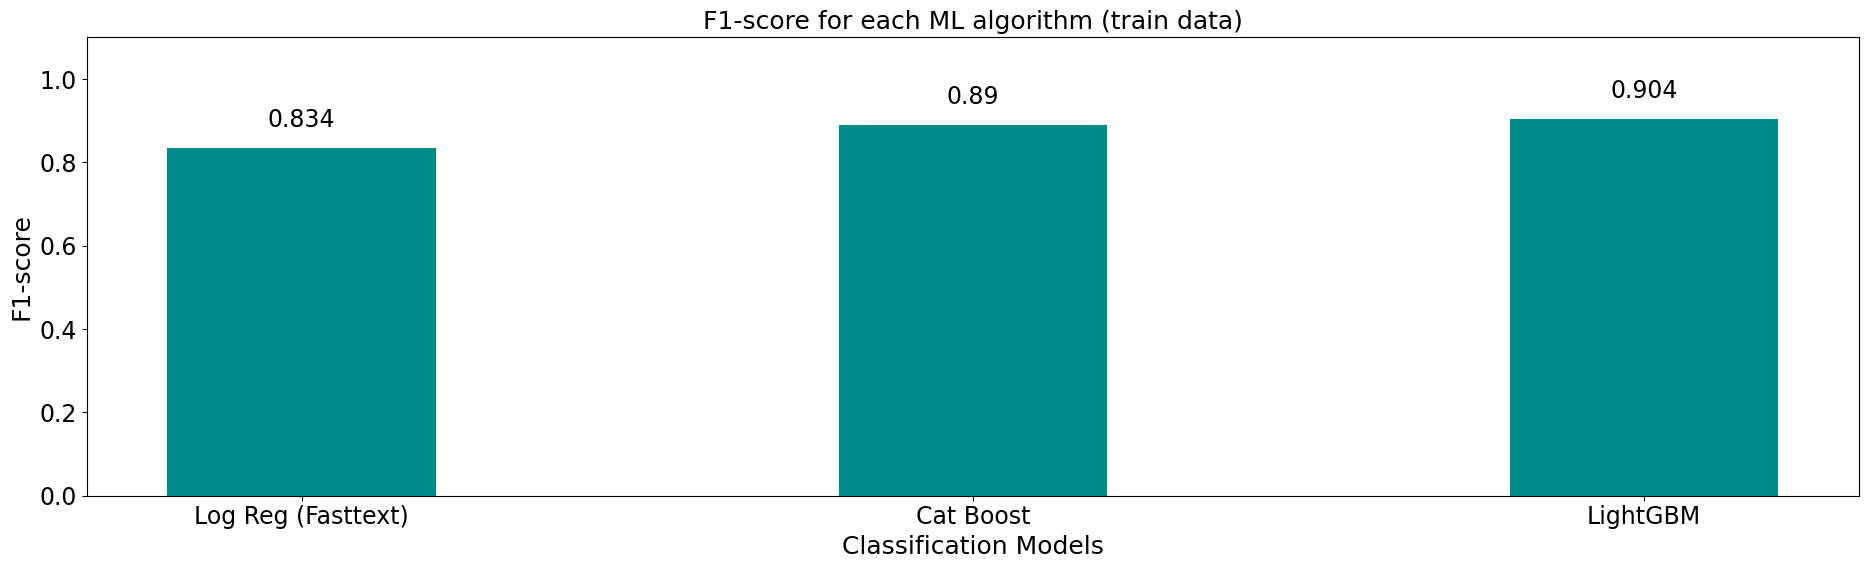

In [142]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17,
                     'text.color' : 'black',
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Fasttext)',
     'Cat Boost',
    'LightGBM']

y = [best_score_logreg,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=18)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout();

#### Логистическая регрессия позволяет получить такие результаты, что:

* **accuracy: 93.99%**

* **f1-score: 0.9439430404145152**

* **923 объектов были верно классифицированы как класс 0** (true negatives)
* **59 объектов были неверно классифицированы как класс 1** (false positives)
* **8 объектов были неверно классифицированы как класс 0** (false negatives)
* **125 объектов были верно классифицированы как класс 1** (true positives)

#### CatBoostClassifier позволяет получить такие результаты, что:

* **accuracy: 98.03%**

* **f1-score: 0.9801384921903853**

* **973 объектов были верно классифицированы как класс 0** (true negatives)
* **9 объектов были неверно классифицированы как класс 1** (false positives)
* **13 объектов были неверно классифицированы как класс 0** (false negatives)
* **120 объектов были верно классифицированы как класс 1** (true positives)


#### LGBMClassifier позволяет получить такие результаты, что:

* **accuracy: 98.21%**

* **f1-score: 0.98175787763345**

* **977 объектов были верно классифицированы как класс 0** (true negatives)
* **5 объектов были неверно классифицированы как класс 1** (false positives)
* **15 объектов были неверно классифицированы как класс 0** (false negatives)
* **118 объектов были верно классифицированы как класс 1** (true positives)

*Общее количество объектов в тестовом наборе данных равно 1115.*

### *Вывод:* По совокупности метрик, делаем вывод, что модель бустинга LightGBM с использованием Fasttext для препроцессинга и векторизации текста показывает лучший результат для решения задачи классификации спама.